<a href="https://colab.research.google.com/github/karthiviz/Directions_China_SKorea/blob/main/osm2graphml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install osmnx

In [ ]:
import osmnx as ox
import networkx as nx
from google.colab import files
ox.config(log_console=True, use_cache=True)

OSMNX library allows us to load OpenStreetMap data natively. I'm loading a simplified version of the highway network of China I've extracted from the OSM file available for China on https://download.geofabrik.de/asia/china.html.

OSMNX has in-built functions to impute speed attribute for the edges, which takes a mean of all max. speed values available on the feature. We're going to override that with slower speeds (since we're calculating this for commercial truck transportation times & not for car/passenger vehicles)

In [ ]:
hwy_speeds = {"motorway": 75, "motorway_link": 70, "primary": 65, "primary_link": 60}
G = ox.graph.graph_from_xml('/content/drive/MyDrive/china_highways.osm', simplify=True)
G = ox.speed.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.speed.add_edge_travel_times(G)

Saving the resulting network to a GraphML file, which can be easily read by well-known network analysis libraries. Also, GraphML files are smaller, and load faster than OSM files.

In [ ]:
ox.io.save_graphml(G, filepath='china_highways_gml.graphml', encoding="utf-8")

We now have the simplified highway road network ready in the graph object G. Plotting it on the map to have a clearer picture of the size / density of the network we're working with.

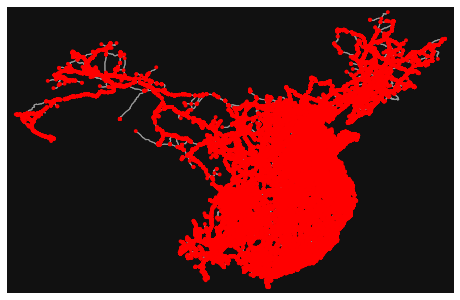

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [6]:
ox.plot_graph(G, node_color='r')

In [7]:
def generate_bounding_box(points):
    y_coordinates, x_coordinates = zip(*points)

    return [max(y_coordinates)+0.025, min(y_coordinates)-0.025, min(x_coordinates)-0.025, max(x_coordinates)+0.025]

In [8]:
origin_point = (36.013423, 120.198944)
destination_point =(39.816431, 116.509003)

points_array = [origin_point,destination_point]
bbox = generate_bounding_box(points_array)

Finding the nearest node on the graph to the origination - destination points of interst, we calculate the travel time between these nearest approximates.

In [ ]:
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)

In [14]:
route = ox.shortest_path(G, origin_node, destination_node)
travel_time = nx.shortest_path_length(G, origin_node, destination_node, weight='travel_time')
hours = travel_time//3600
if hours >= 8:
    hours *= 1.4
modulo_secs = travel_time%3600
minutes = modulo_secs//60
modulo_secs = modulo_secs%60
print("Estimated time calculated at ave. speed = free flow speed - 20kmph")
print("Driver rest time factored at 3h of rest every 8h of driving")
print(f"Estimated travel time: {int(hours)}h {int(minutes)}m {round(modulo_secs,0)}s")

Estimated time calculated at ave. speed = free flow speed - 20kmph
Driver rest time factored at 3h of rest every 8h of driving
Estimated travel time: 11h 35m 36.0s


Plotting the route on map to visually confirm the path chosen by the shortest path algorithm. The plot is mirrored around the vertical axis.

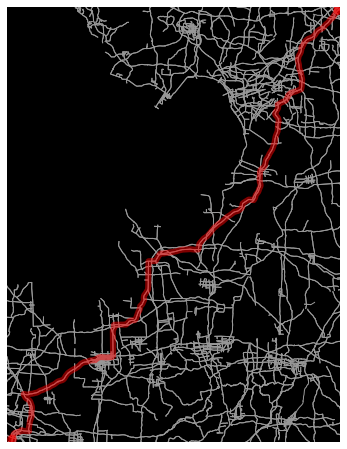

In [13]:
fig, ax = ox.plot_graph_route(G, route, bbox=bbox, route_linewidth=6, node_size=0, bgcolor='k')